# Customer Segmentation using RFM and K-Means
This project segments customers based on their purchasing behavior using RFM analysis and K-Means clustering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import datetime

In [3]:
# Load the sample dataset
file_path = 'online_retail_sample.csv'
df = pd.read_csv(file_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536366,71053,WHITE METAL LANTERN,6,12/1/2010 8:28,3.39,17850,United Kingdom
2,536367,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:34,2.75,13047,United Kingdom
3,536368,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:35,3.39,13047,United Kingdom
4,536369,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:45,3.39,13047,United Kingdom


## Exploratory Data Analysis (EDA)

Shape of data: (5, 8)

Missing values per column:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Top 5 most purchased products:
Description
WHITE HANGING HEART T-LIGHT HOLDER     1
WHITE METAL LANTERN                    1
CREAM CUPID HEARTS COAT HANGER         1
KNITTED UNION FLAG HOT WATER BOTTLE    1
RED WOOLLY HOTTIE WHITE HEART.         1
Name: count, dtype: int64

Top countries by transaction volume:
Country
United Kingdom    5
Name: count, dtype: int64


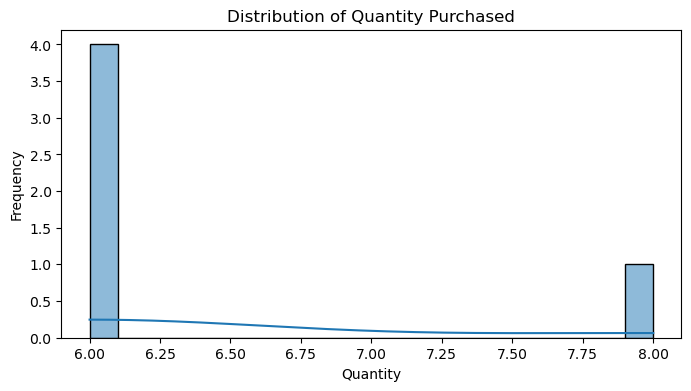

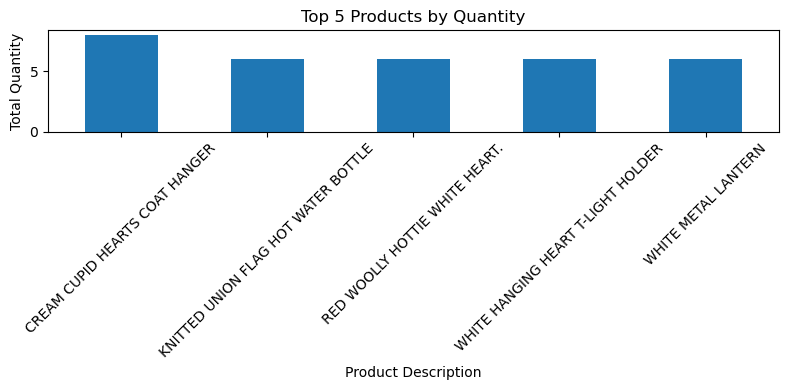

In [4]:
# Exploratory Data Analysis (EDA)
print("Shape of data:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())

print("\nTop 5 most purchased products:")
print(df['Description'].value_counts().head())

print("\nTop countries by transaction volume:")
print(df['Country'].value_counts().head())

# Plot distribution of Quantity
plt.figure(figsize=(8, 4))
sns.histplot(df['Quantity'], bins=20, kde=True)
plt.title('Distribution of Quantity Purchased')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

# Plot top 5 products by quantity
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(5)
top_products.plot(kind='bar', title='Top 5 Products by Quantity', ylabel='Total Quantity', xlabel='Product Description', figsize=(8, 4))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove negative or zero quantities and unit prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

In [6]:
# Reference date for Recency calculation
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum()
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
13047,1,3,62.68
17850,1,2,35.64


In [7]:
# Scale the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled[:5]

array([[ 0.,  1.,  1.],
       [ 0., -1., -1.]])

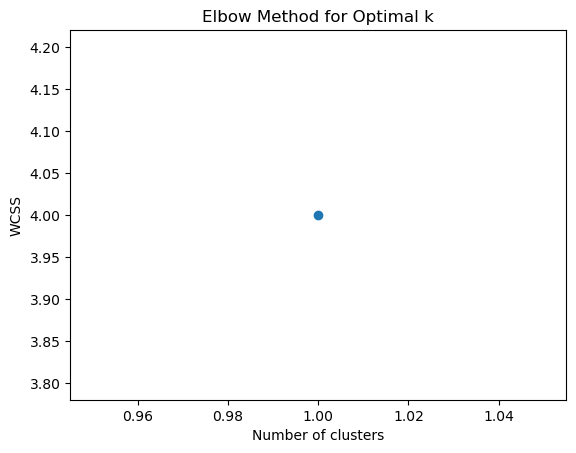

In [10]:
# Elbow method to determine optimal k
wcss = []
max_k = min(11, len(rfm_scaled))  # prevents k from exceeding number of samples

for k in range(1, max_k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, max_k), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()


In [13]:
# Apply KMeans
# Automatically choose safe number of clusters (but max 4)
k = min(4, len(rfm_scaled))

if k < 2:
    print("❌ Not enough customers to form clusters. Add more data.")
else:
    kmeans = KMeans(n_clusters=k, random_state=42)
    rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
    print(f"✅ Applied KMeans with {k} clusters.")


✅ Applied KMeans with 2 clusters.


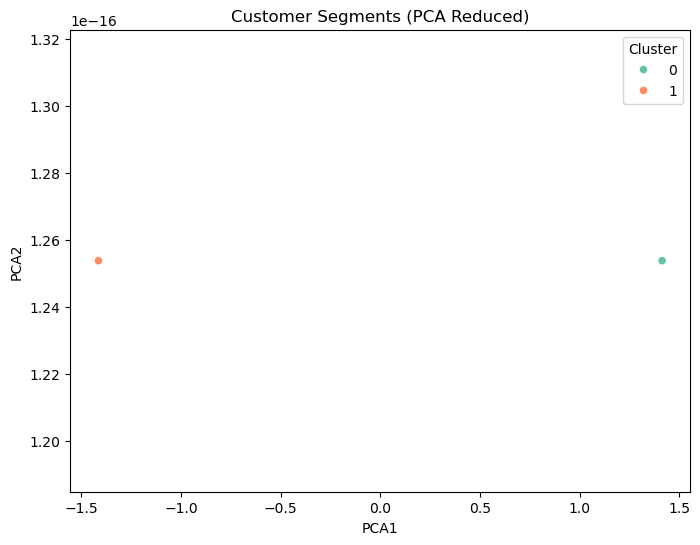

In [14]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Customer Segments (PCA Reduced)')
plt.show()

In [15]:
# Cluster Summary
cluster_summary = rfm.groupby('Cluster').mean()
cluster_summary

,Recency,Frequency,Monetary,PCA1,PCA2
Cluster,,,,,
0,1.0,3.0,62.68,1.414214,1.253717e-16
1,1.0,2.0,35.64,-1.414214,1.253717e-16


### Business Recommendations
- **Cluster 0:** High Recency, Low Monetary – Likely new or occasional buyers.
- **Cluster 1:** Low Recency, High Frequency – Loyal and frequent buyers.
- **Cluster 2:** High Recency, Low Frequency – Lost customers or inactive users.
- **Cluster 3:** Medium Recency, High Monetary – Potential VIP customers.